<a href="https://colab.research.google.com/github/ptats/ml101-grad-workshop/blob/master/notebooks/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Create your own image classifier - including the dataset**

by: Paula Tattam. An extraction of Fastai [Lesson 1](https://https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb) and [Lesson 2](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)

In this workshop you will get to create your own image classification dataset using google images. You will then build and train your own image classifier using the [fastai V1 library](https://www.fast.ai/2018/10/02/fastai-ai/). fastai is a python machine learning library built on top of the popular [PyTorch v1.0](https://engineering.fb.com/ai-research/facebook-accelerates-ai-development-with-new-partners-and-production-capabilities-for-pytorch-1-0/) machine learning framework.

Fastai is a library that allows you to rapidly build and train your own  machine learning models utilising transfer learning from a range of current state of the art models.

See setup instructions for google collab [here.]()

In [0]:
# run once
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My\ Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *

# **Step 1: Pick a classification task**
For step 1 make up an image classification task. It can be any topic of your choice but the images will need to be available through [google images.](https://images.google.com/?gws_rd=ssl) For example:

*   Disney character classifier
*   Hotdogs or legs
*   Big cat classifier (tigers, lions, cheetahs, etc...)

Please try keep it PG and don't pick too many different classes as you will need to repeat the below step for each class.

Google image search allows you to exclude certain words in a search, combine searchs and a number of other operations.

For example, to search dog but exlcude wolves, use the `-` operator:

`dog -wolf`

See more options [here](https://support.google.com/websearch/answer/2466433?visit_id=637175902163553047-3698874010&p=adv_operators&hl=en&rd=1).

# **Step 2: Download URLs**

Now you will need to download each image URL to a file. This can be done by using a small snippet of JavaScript. You will need to open the javascript console which can be done as follows:

* Chrome: `ctrl+shift+j` (macOS: `Cmd+Opt+j`)
* Firefox: `ctrl+shit+k` (macOS: `Cmd+Opt+k`)

This will open up a window where you will paste the below code snippet. Before you paste the below code, scroll down in your search results window a few times to load images. Only the displayed search image urls will be copied.

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Repeat this step for each classification category that you have chosen. Once the file is downloaded, rename as per the following convention:

`urls_<label>.csv`




# **Step 3: Create directories and upload files**

Choose an appropriate name for your directory and create a list of your class labels. Edit the below cells as noted and run all cells until the next text block.



In [0]:
# UPDATE ME: add your labels as per the label used for the csv file
labels = ["zoro", "sanji", "nami", "brook", "robin", "chopper", "frankie", "luffy", "usopp"] 

In [0]:
# UPDATE ME: name as per your classifcation task
name = "one_piece_crew"

In [0]:
for label in labels:
  path = Path(f'data/{name}') 
  dest = path/label
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

Lastly, we upload the csv files. Open the side menu, press 'Upload' and select your files. 

![Upload Images](https://github.com/ptats/ml101-grad-workshop/tree/master/images)

In [37]:
for label in labels:
  filename = f"urls_{label}.csv"
  dest = path/label
  download_images(path/filename, dest, max_pics=200)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [38]:
for label in labels:
  print(label)
  verify_images(path/label, delete=True, max_size=500)

zoro


sanji


nami


brook


robin


chopper


frankie


luffy


usopp


In [0]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [40]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['brook',
  'chopper',
  'frankie',
  'luffy',
  'nami',
  'robin',
  'sanji',
  'usopp',
  'zoro'],
 9,
 1296,
 324)

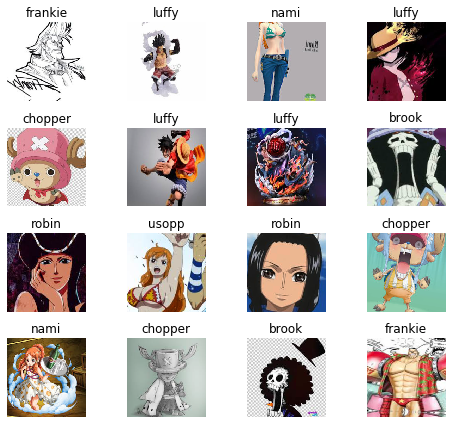

In [41]:
data.show_batch(rows=4, figsize=(7,6))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [43]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.636781,1.161042,0.351852,00:14
1,1.854639,1.032800,0.296296,00:13
2,1.418503,1.048047,0.277778,00:13
3,1.178217,1.019720,0.290123,00:14


In [0]:
learn.save('stage-1')

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

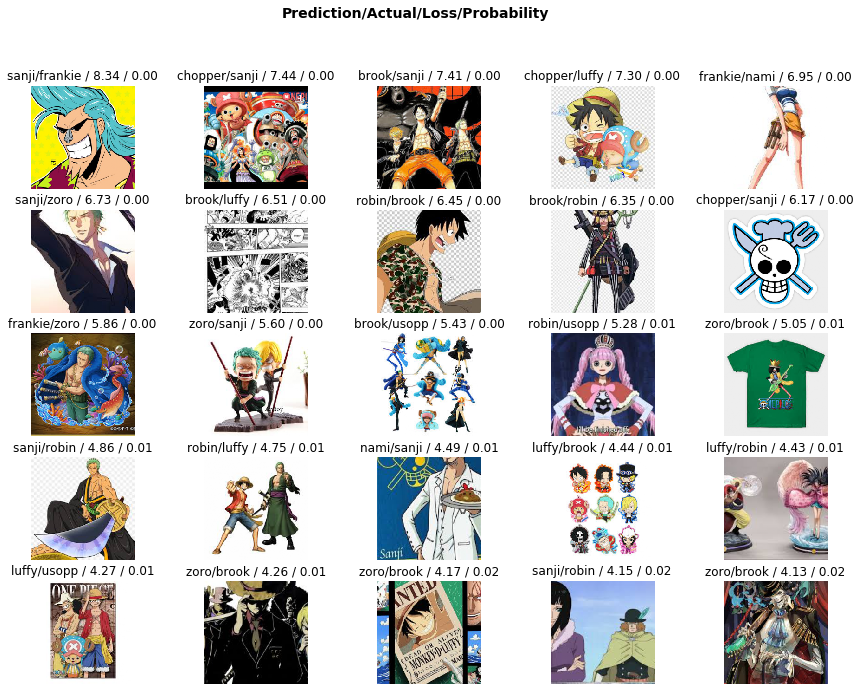

In [54]:
interp.plot_top_losses(25, figsize=(15,11))

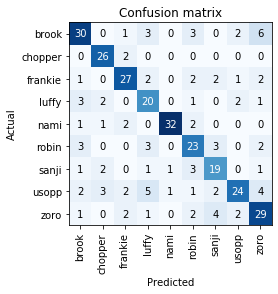

In [47]:
interp.plot_confusion_matrix()

In [48]:
interp.most_confused(min_val=2)

[('brook', 'zoro', 6),
 ('usopp', 'luffy', 5),
 ('usopp', 'zoro', 4),
 ('zoro', 'sanji', 4),
 ('brook', 'luffy', 3),
 ('brook', 'robin', 3),
 ('luffy', 'brook', 3),
 ('robin', 'brook', 3),
 ('robin', 'luffy', 3),
 ('robin', 'sanji', 3),
 ('sanji', 'robin', 3),
 ('usopp', 'chopper', 3),
 ('brook', 'usopp', 2),
 ('chopper', 'frankie', 2),
 ('frankie', 'luffy', 2),
 ('frankie', 'robin', 2),
 ('frankie', 'sanji', 2),
 ('frankie', 'zoro', 2),
 ('luffy', 'chopper', 2),
 ('luffy', 'usopp', 2),
 ('nami', 'frankie', 2),
 ('nami', 'robin', 2),
 ('robin', 'zoro', 2),
 ('sanji', 'chopper', 2),
 ('usopp', 'brook', 2),
 ('usopp', 'frankie', 2),
 ('usopp', 'sanji', 2),
 ('zoro', 'frankie', 2),
 ('zoro', 'robin', 2),
 ('zoro', 'usopp', 2)]

In [0]:
learn.unfreeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


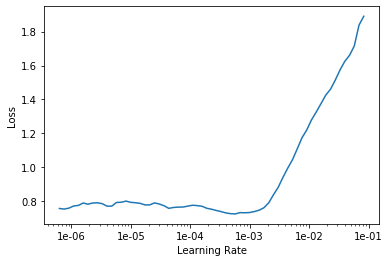

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.801994,1.003205,0.277778,00:14
1,0.776954,0.993462,0.271605,00:14


In [0]:
learn.save('stage-2')

Not a very accurate model

Cleaning Up

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch())

In [61]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1620 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
robin,robin,robin,robin,robin
Path: data/one_peice_crew;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/one_peice_crew;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [62]:
ds, idx = DatasetFormatter().from_toplosses(learn_cln)